## Scanpy `pbmc4k`

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pylab as plt

In [3]:
results_out_root = '/home/jupyter/data/10x/out/'
marker_genes_txt = '/home/jupyter/data/10x/pbmc_marker_genes.txt'

input_root = '/home/jupyter/data/10x/out/pbmc4k__raw__mtx_output/'
output_prefix = 'pbmc4k_raw'

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = os.path.join(results_out_root, f'{output_prefix}.h5ad')

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.2 scipy==1.3.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [4]:
sc.settings.set_figure_params(dpi=80)

In [5]:
adata = sc.read_10x_mtx(
    input_root,
    var_names='gene_symbols',
    cache=True) 

... reading from cache file cache/home-jupyter-data-10x-out-pbmc4k__raw__mtx_output-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

## Load marker genes

In [7]:
from collections import defaultdict
marker_genes_dict = defaultdict(list)

with open(marker_genes_txt, 'r') as f:
    while True:
        cluster_name = f.readline().strip()
        gene_name = f.readline().strip()
        sense = f.readline().strip()
        if sense == '+':
            sense = 1
        else:
            sense = -1
        if cluster_name == "":
            break
        marker_genes_dict[cluster_name].append((gene_name, sense))
        
all_marker_genes = []
for v in marker_genes_dict.values():
    all_marker_genes += [x[0] for x in v]
all_marker_genes = np.unique(all_marker_genes).tolist()

## Preprocessing

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


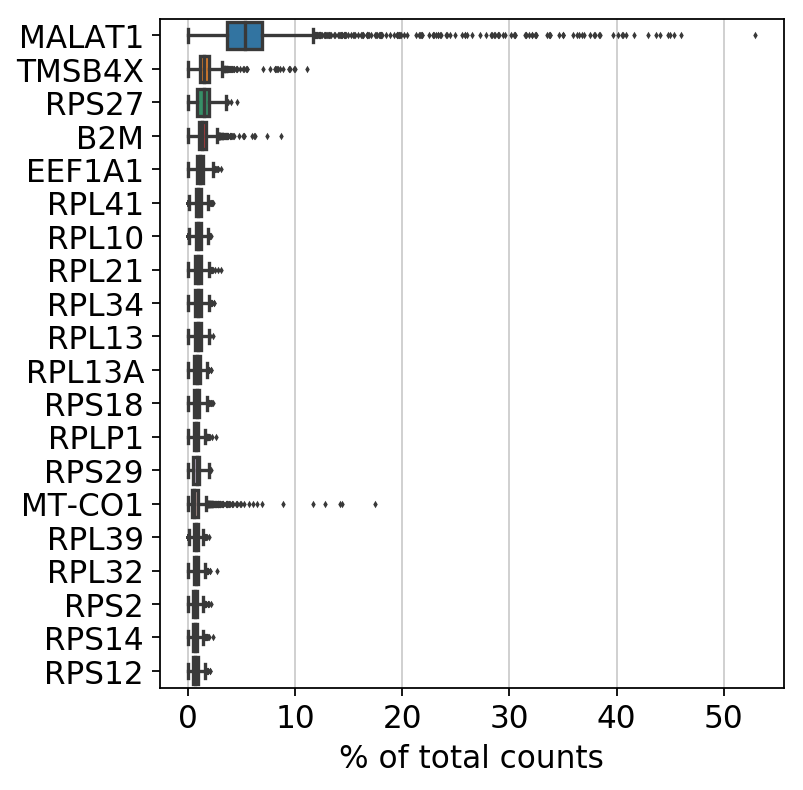

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, save="_" + output_prefix + '.pdf')

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 2 cells that haveless than 200 genes expressed
filtered out 3109 genes that are detectedin less than 3 cells


In [10]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

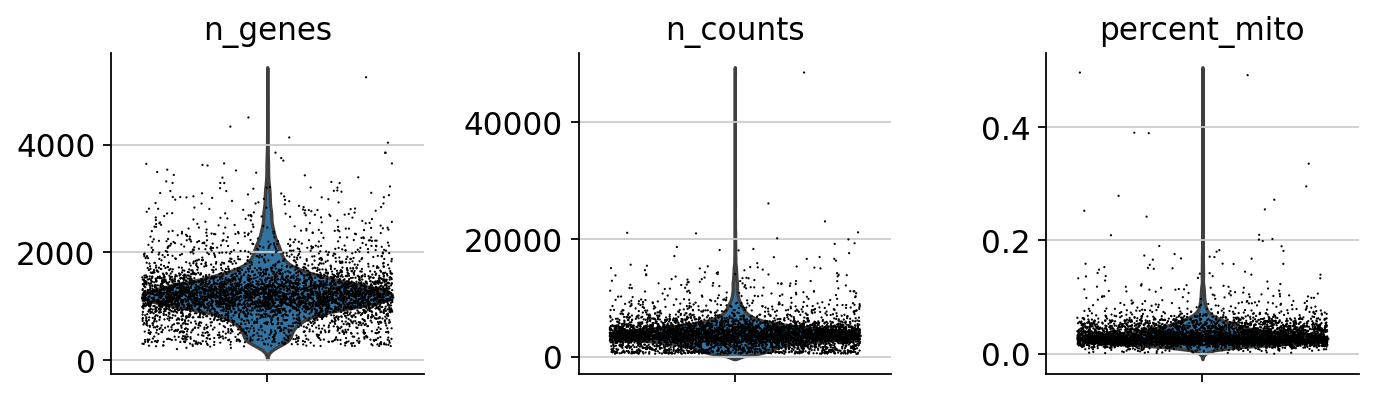

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

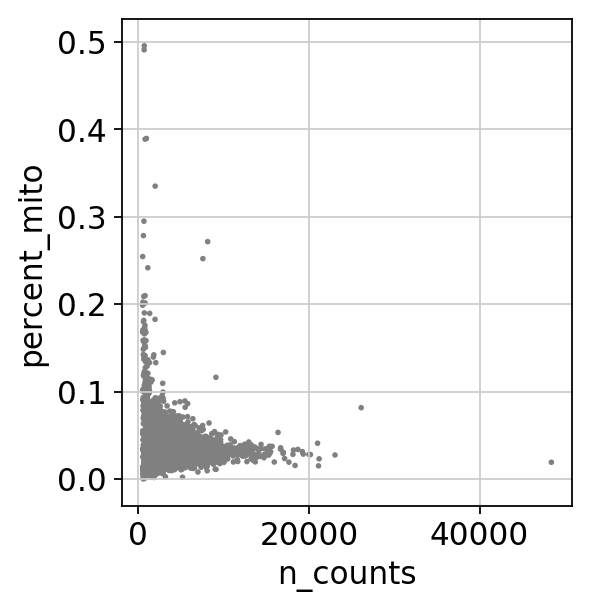

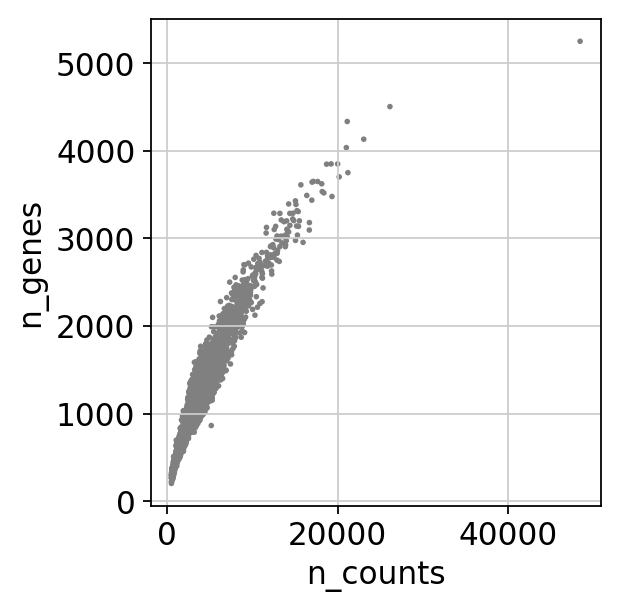

In [12]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [13]:
adata

AnnData object with n_obs × n_vars = 4711 × 16713 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [14]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [16]:
sc.pp.log1p(adata)

In [17]:
adata.raw = adata

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


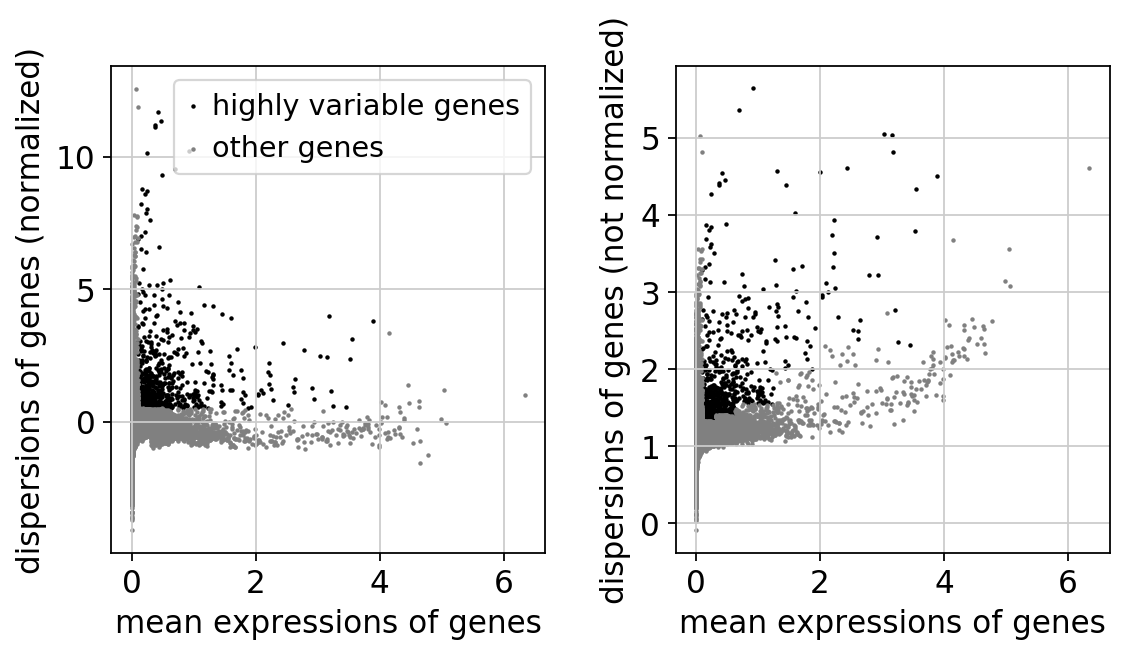

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [19]:
# all_marker_genes_set = set(all_marker_genes)
# n = 0
# hvg_bool_list = []
# for gene_name in adata.var.index:
#     if gene_name in all_marker_genes_set:
#         hvg_bool_list.append(True)
#     else:
#         hvg_bool_list.append(False)
# adata.var['highly_variable'] = hvg_bool_list

In [20]:
adata = adata[:, adata.var['highly_variable']]

In [21]:
# sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

In [22]:
sc.pp.scale(adata, max_value=10)

/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Principal component analysis

In [23]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=100)

computing PCA with n_comps = 100
computing PCA on highly variable genes
    finished (0:00:00)


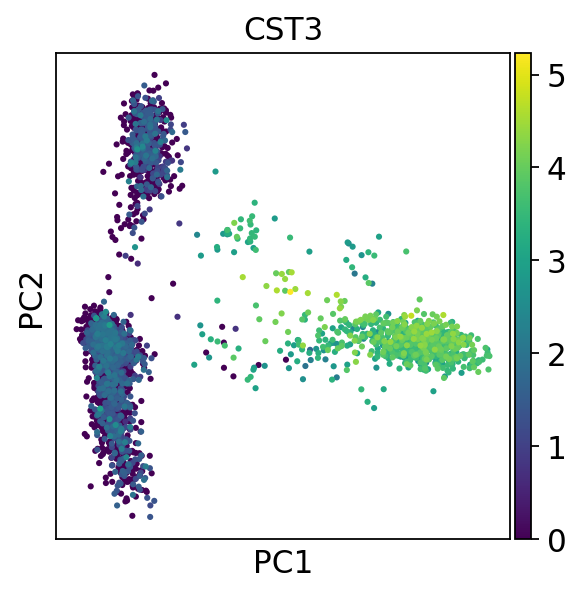

In [24]:
sc.pl.pca(adata, color='CST3')

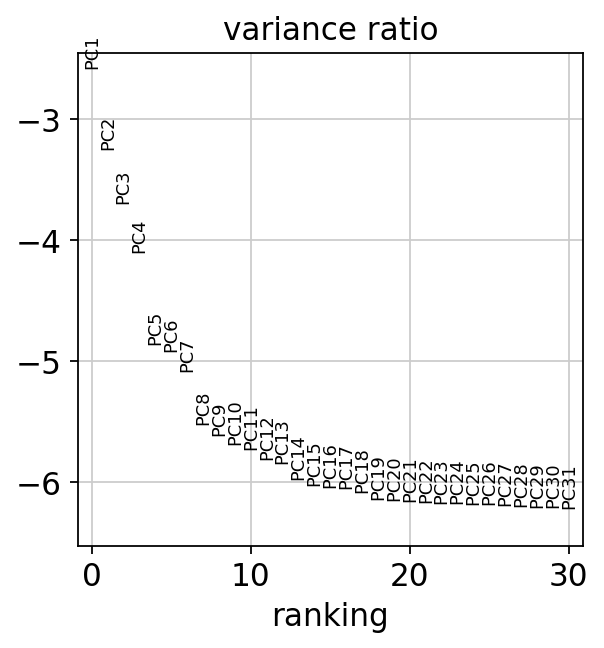

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

In [26]:
adata

AnnData object with n_obs × n_vars = 3914 × 966 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [27]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


In [28]:
sc.tl.umap(adata)

computing UMAP


/opt/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


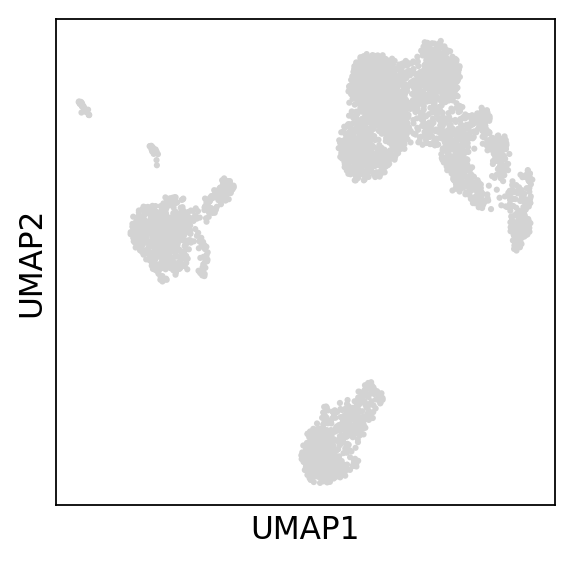

In [29]:
sc.pl.umap(adata)
# sc.pl.umap(adata,
#            color=['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
#                   'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
#                   'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP'],
#            save="_" + output_prefix + '.pdf')

In [30]:
adata.write(results_file)

## Clustering

In [31]:
adata = sc.read(results_file)

In [32]:
# raw -> 0.7
# dtm -> 1.0
louvain_resolution = 5.0
sc.tl.louvain(adata, resolution=louvain_resolution)

if 'cell_type' in adata.obs.columns:
    adata.obs = adata.obs.drop(columns=['cell_type'])
adata.obs.insert(len(adata.obs.columns), 'cell_type', adata.obs['louvain'].values.tolist())

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 44 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


In [33]:
# considered_cell_types = ['Cytotoxic T cell', 'Megakaryocyte', 'CD16+ monocyte', 'CD4+ T cell', 'CD14+ monocyte', 'B cell']

considered_cell_types = list(marker_genes_dict.keys())

In [34]:
considered_cell_types

['CD4+ T cell',
 'Cytotoxic T cell',
 'B cell',
 'Natural killer cell',
 'CD14+ monocyte',
 'CD16+ monocyte',
 'Dendritic cell',
 'Plasmacytoid dendritic cell',
 'Plasma cell',
 'Megakaryocyte']

In [35]:
max_cluster_index = max([int(x) for x in adata.obs['louvain'].values.tolist()])
score_matrix = np.zeros((max_cluster_index + 1, len(considered_cell_types)))
for cluster_index in range(max_cluster_index + 1):
    print(cluster_index)
    cluster_adata = adata[adata.obs['louvain'] == str(cluster_index), :]
    for cell_type_index, cell_type in enumerate(considered_cell_types):
        cell_type_ann = marker_genes_dict[cell_type]
        score = 0.
        for gene_name, sense in cell_type_ann:
            try:
                score += np.sum(cluster_adata[:, gene_name].X * sense).item()
            except:
                pass
        score_matrix[cluster_index, cell_type_index] = score

0


/opt/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


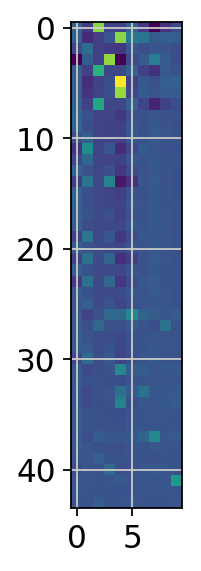

In [36]:
plt.imshow(score_matrix)

In [37]:
cell_type_assignment = np.argmax(score_matrix, -1)
for i, v in enumerate(adata.obs['louvain'].values):
    adata.obs['cell_type'].values[i] = considered_cell_types[cell_type_assignment[int(v)]]

... storing 'cell_type' as categorical


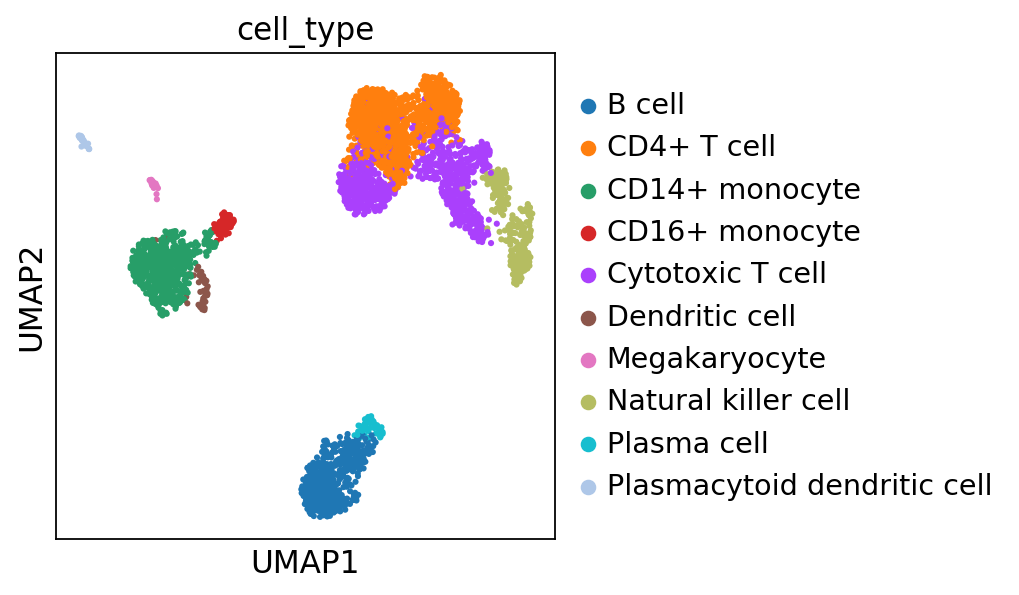

<Figure size 320x320 with 0 Axes>

In [38]:
import matplotlib.pylab as plt
sc.pl.umap(adata, color=['cell_type'], save="_" + output_prefix + '_big.pdf')
# sc.pl.umap(adata[adata.obs['cell_type'] == 'Megakaryocyte', :], size=5)
plt.tight_layout()

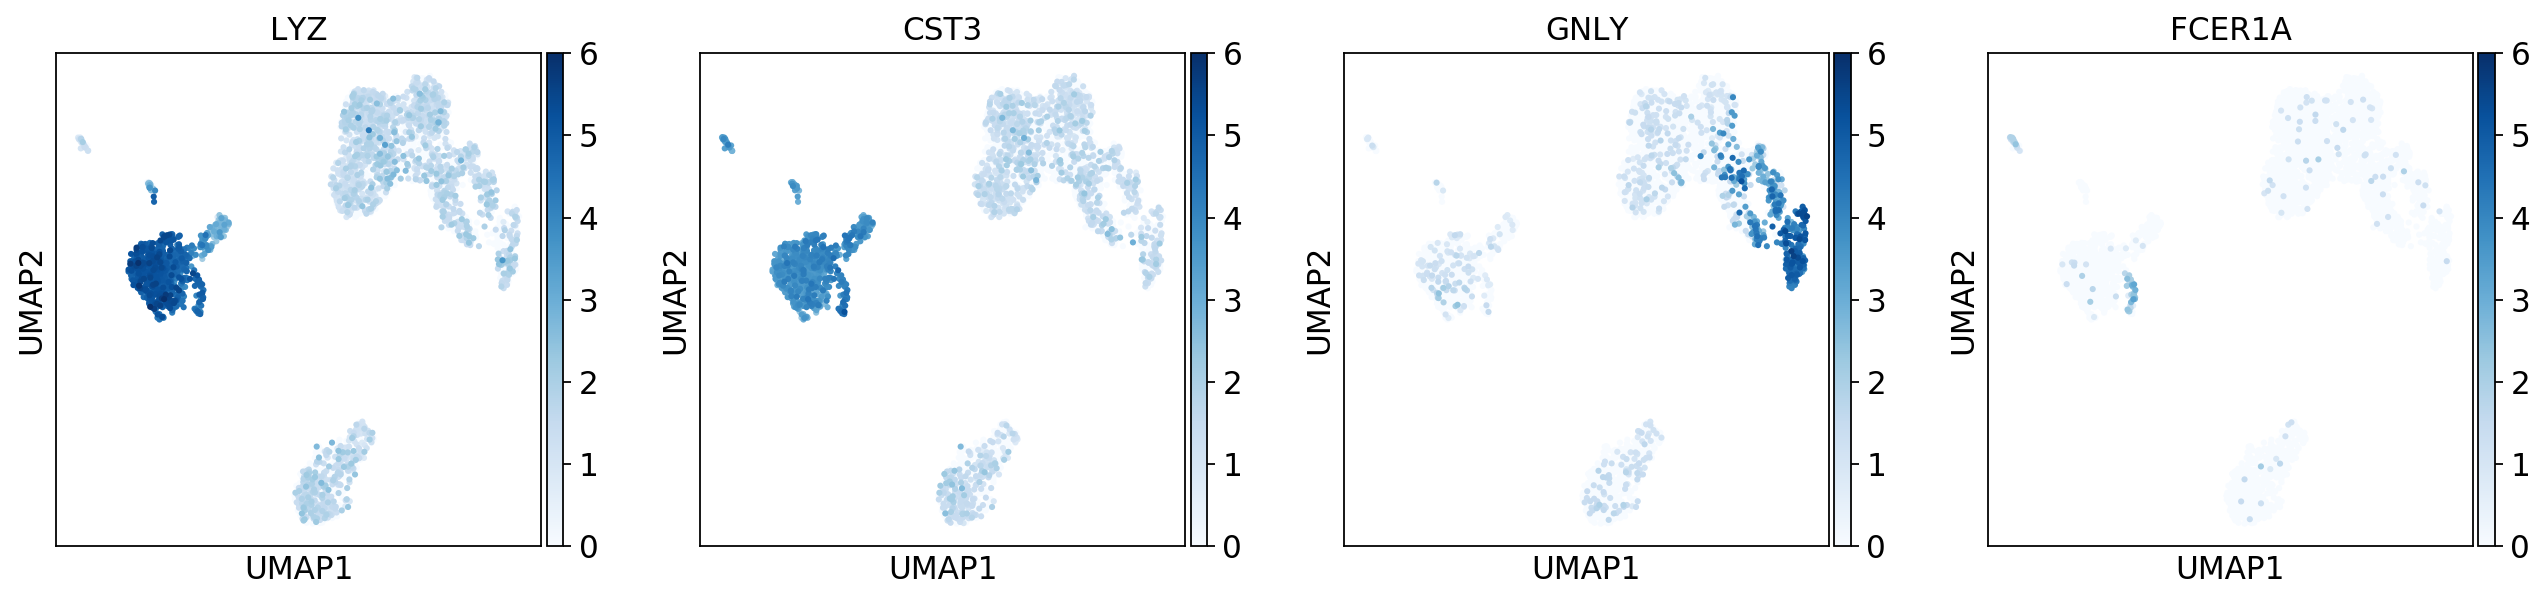

<Figure size 320x320 with 0 Axes>

In [76]:
import matplotlib.pylab as plt
sc.pl.umap(adata, color=['LYZ', 'CST3', 'GNLY', 'FCER1A'], color_map=plt.cm.Blues, vmax=6, save="_markers_" + output_prefix + '.pdf')
plt.tight_layout()

In [40]:
adata.write(results_file)

## Marker genes

In [41]:
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


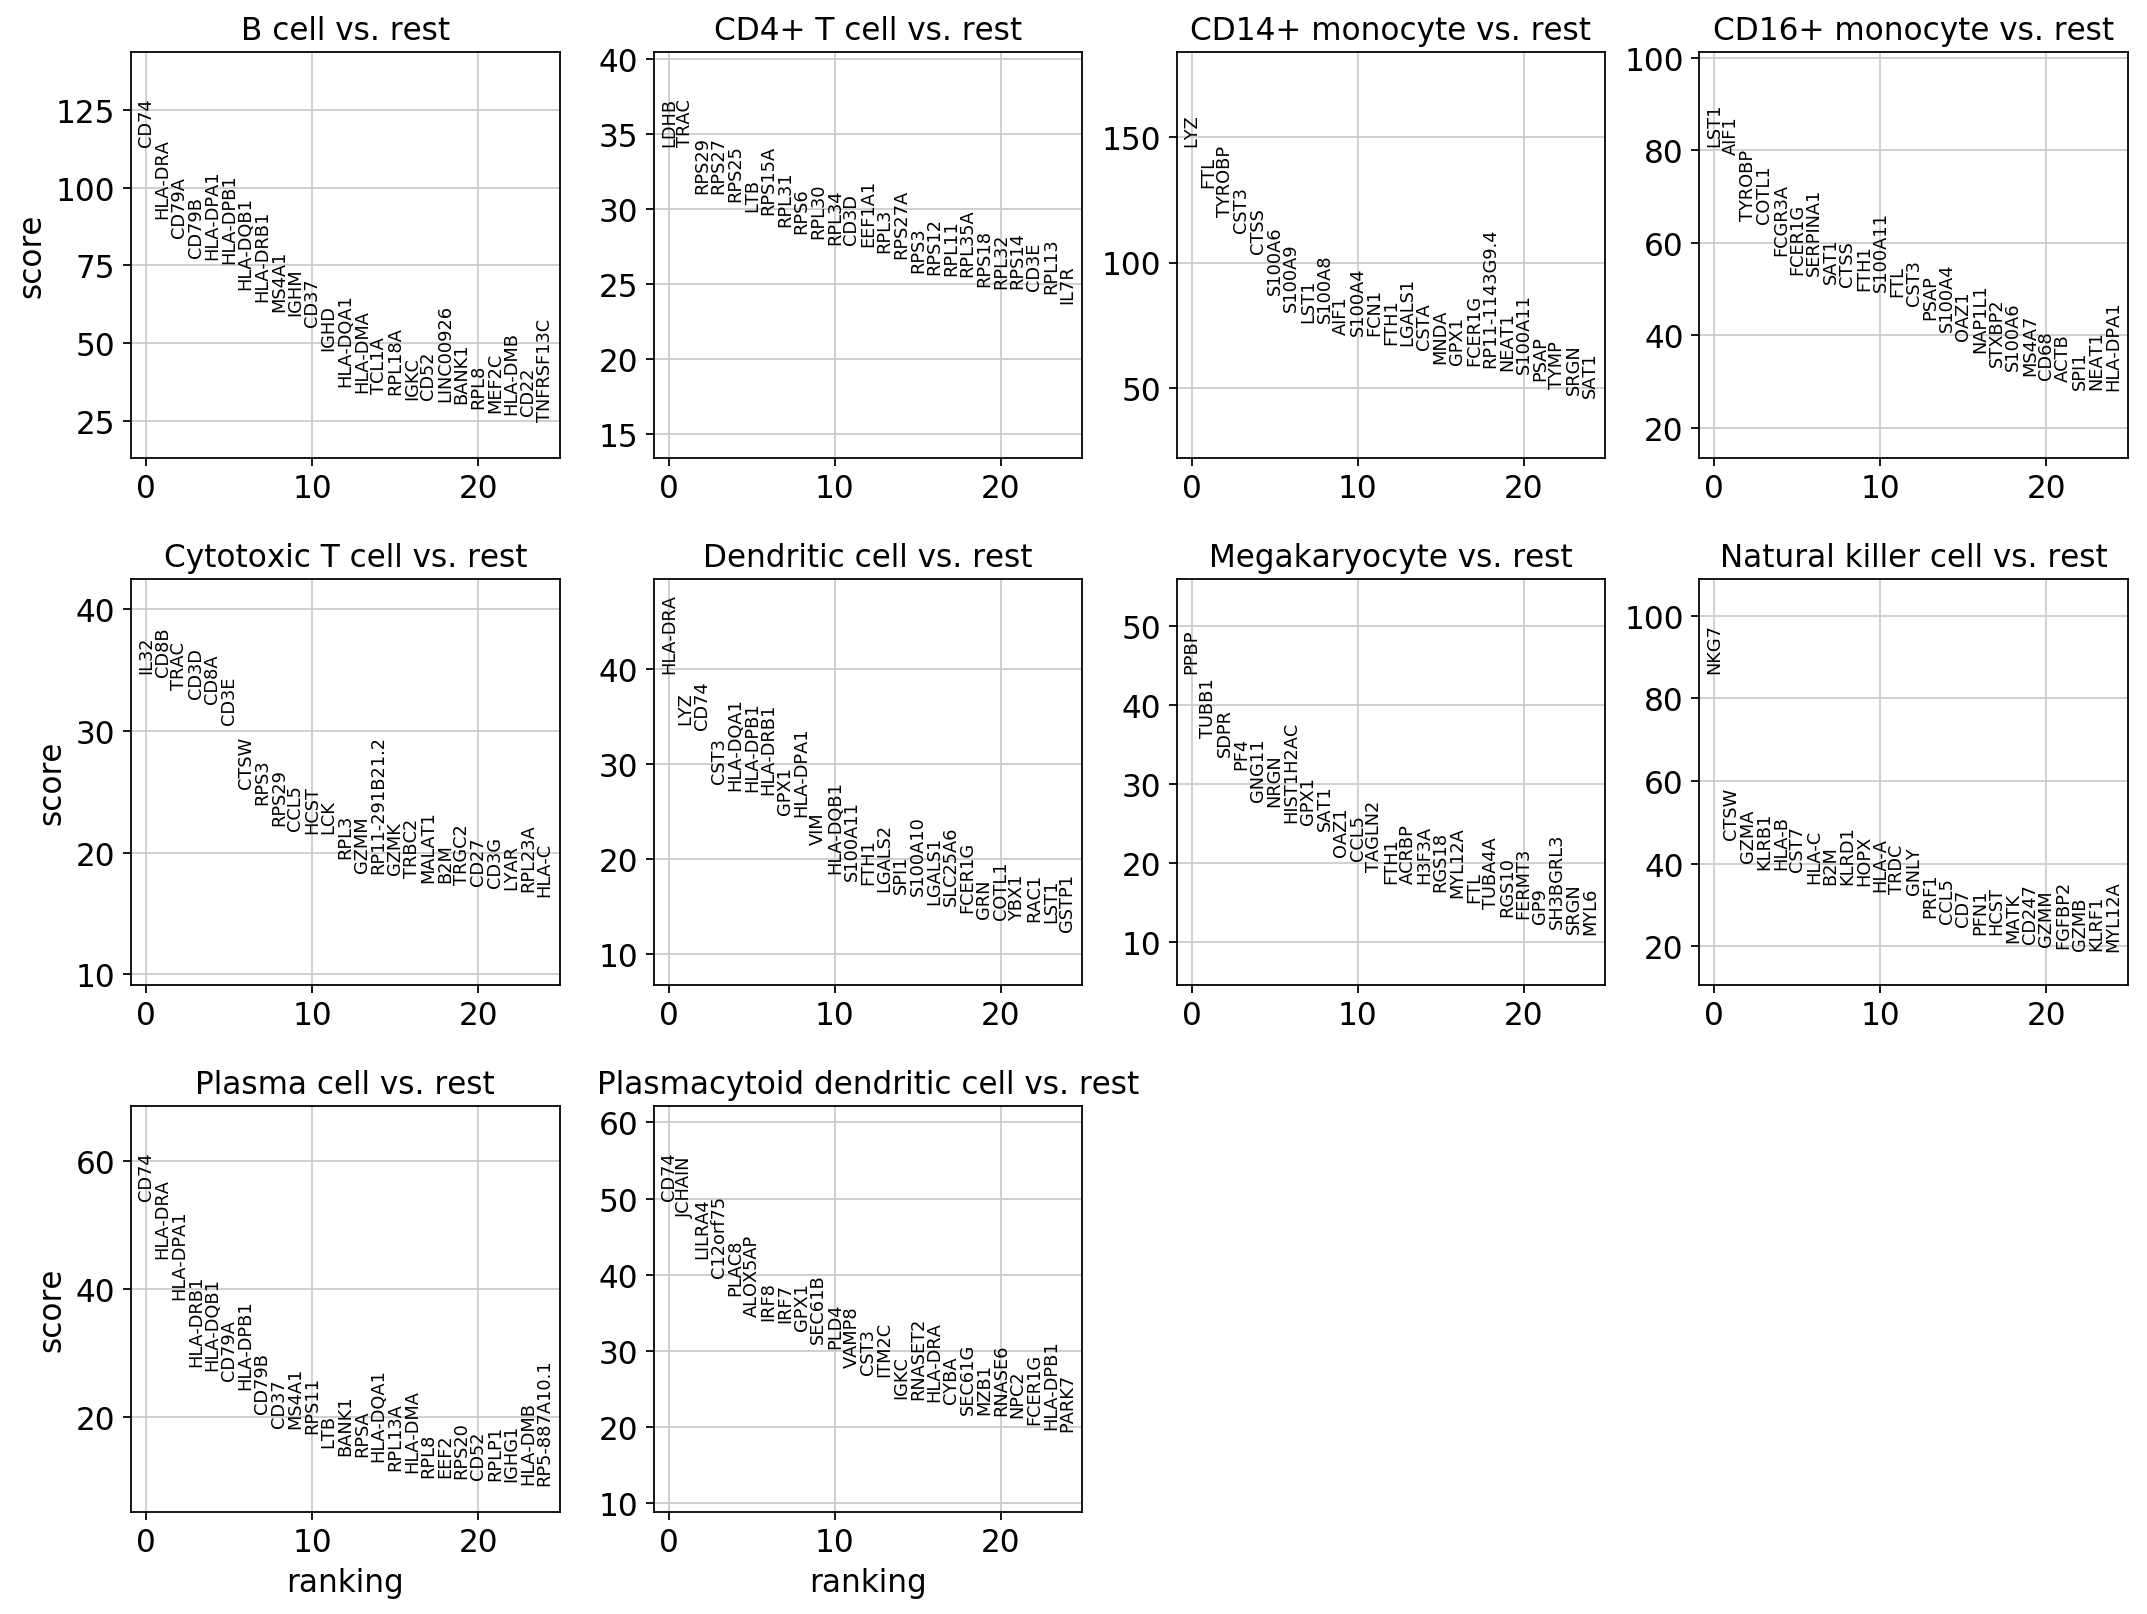

In [47]:
sc.tl.rank_genes_groups(adata, 'cell_type', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [48]:
adata.write(results_file)

In [49]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [50]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,B cell,CD4+ T cell,CD14+ monocyte,CD16+ monocyte,Cytotoxic T cell,Dendritic cell,Megakaryocyte,Natural killer cell,Plasma cell,Plasmacytoid dendritic cell
0,CD74,LDHB,LYZ,LST1,IL32,HLA-DRA,PPBP,NKG7,CD74,CD74
1,HLA-DRA,TRAC,FTL,AIF1,CD8B,LYZ,TUBB1,CTSW,HLA-DRA,JCHAIN
2,CD79A,RPS29,TYROBP,TYROBP,TRAC,CD74,SDPR,GZMA,HLA-DPA1,LILRA4
3,CD79B,RPS27,CST3,COTL1,CD3D,CST3,PF4,KLRB1,HLA-DRB1,C12orf75
4,HLA-DPA1,RPS25,CTSS,FCGR3A,CD8A,HLA-DQA1,GNG11,HLA-B,HLA-DQB1,PLAC8


In [61]:
def shorten(name, length=10):
    if len(name) < length:
        return name
    else:
        return name[:length - 3] + "..."
    
def conc(names, scores, just_values=False):
    s = sorted(zip(names, scores), key=lambda x: x[1], reverse=True)
    l = []
    if just_values:
        for name, score in s:
            l.append(score)
    else:
        for name, score in s:
            l.append(f'{shorten(name)} ({score:.1f})')
    return np.asarray(l)

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame(
    {group: conc(result['names'][group], result['logfoldchanges'][group])
    for group in groups})
df_vals = pd.DataFrame(
    {group: conc(result['names'][group], result['logfoldchanges'][group], just_values=True)
    for group in groups})

In [71]:
from matplotlib import colors

def background_gradient(s, m, M, cmap='PuBu', low=0, high=0, source=None):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    l = s.tolist()
    v = []
    for elem in l:
        v.append(float(elem[elem.find('(')+1:-1]))
    normed = norm(v)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    out = ['background-color: %s' % color for color in c]
    return out

d = dict(selector="th",
    props=[('text-align', 'center')])

df.head(20).style\
.set_properties(**{'width':'10em', 'text-align':'right'})\
.set_table_styles([d])\
.apply(
    background_gradient,
    cmap='Blues',
    source=df_vals,
    m=1,
    M=15,
    low=0,
    high=0.2)

,B cell,CD4+ T cell,CD14+ monocyte,CD16+ monocyte,Cytotoxic T cell,Dendritic cell,Megakaryocyte,Natural killer cell,Plasma cell,Plasmacytoid dendritic cell
0,IGHD (7.5),TSHZ2 (3.7),S100A12 (6.6),FCGR3A (6.8),RP11-29... (4.9),CLEC10A (6.8),CTTN (13.3),GNLY (6.5),AL92876... (7.4),LRRC26 (11.6)
1,IGHM (6.6),CD40LG (3.1),LYZ (6.5),MS4A7 (6.0),CD8B (4.7),FCER1A (6.5),PF4 (13.2),KLRC1 (6.4),RP5-887... (7.3),SCT (11.3)
2,CD79A (6.6),FHIT (3.0),RP11-11... (6.5),CSF1R (5.7),CD8A (4.7),CST3 (4.9),PPBP (13.0),TRDC (6.3),IGHG1 (6.7),CLEC4C (10.3)
3,TCL1A (6.4),MAL (2.8),VCAN (6.3),LINC01272 (5.7),TRGC2 (3.1),LYZ (4.9),HRAT92 (12.8),KLRF1 (6.1),IGHG3 (6.5),LILRA4 (9.5)
4,FCER2 (6.4),ITM2A (2.1),CSTA (6.2),LRRC25 (5.4),GZMK (3.1),HLA-DQA1 (4.5),SDPR (12.5),NKG7 (5.9),IGHA1 (6.3),TPM2 (9.0)
5,LINC00926 (6.3),LEF1 (2.1),S100A8 (6.1),SIGLEC10 (5.4),CCL5 (2.8),HLA-DPB1 (4.1),CMTM5 (12.4),TRGC1 (5.7),JCHAIN (4.6),SERPINF1 (8.2)
6,MS4A1 (6.1),AQP3 (2.1),MNDA (6.1),LST1 (5.4),CRTAM (2.6),HLA-DRA (4.0),TMEM40 (12.0),KLRD1 (5.7),MS4A1 (4.1),LINC00996 (8.2)
7,RP11-69... (6.0),TRAC (2.1),CD14 (6.0),SERPINA1 (5.0),NELL2 (2.5),LGALS2 (4.0),TUBB1 (12.0),HOPX (5.4),CD79A (4.1),DNASE1L3 (7.9)
8,IGKC (5.9),TRAT1 (2.1),FCN1 (6.0),AIF1 (5.0),CTSW (2.3),HLA-DPA1 (3.9),GP9 (12.0),FGFBP2 (5.4),POU2AF1 (4.1),JCHAIN (7.8)
9,CD79B (5.6),IL7R (2.0),RBP7 (6.0),LILRB2 (4.9),AC09258... (2.3),RP11-11... (3.9),TREML1 (11.5),SPON2 (5.2),BANK1 (3.9),IL3RA (7.6)


In [ ]:
# sc.tl.rank_genes_groups(adata, 'cell_type', groups=['0'], reference='1', method='wilcoxon')
# sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
# adata = sc.read(results_file)

In [ ]:
# sc.tl.rank_genes_groups(adata, 'louvain', groups=['12'], reference='13', method='wilcoxon')
# sc.pl.rank_genes_groups(adata, groups=['12'], n_genes=20)

In [ ]:
# sc.pl.rank_genes_groups_violin(adata, groups='12', n_genes=8)

In [ ]:
# adata = sc.read(results_file)
# sc.pl.rank_genes_groups_violin(adata, groups='13', n_genes=8)

In [ ]:
# sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

In [ ]:
# new_cluster_names = [
#     'CD4 T', 'CD14+ Monocytes',
#     'B', 'CD8 T',
#     'NK', 'FCGR3A+ Monocytes',
#     'Dendritic', 'Megakaryocytes']
# adata.rename_categories('louvain', new_cluster_names)

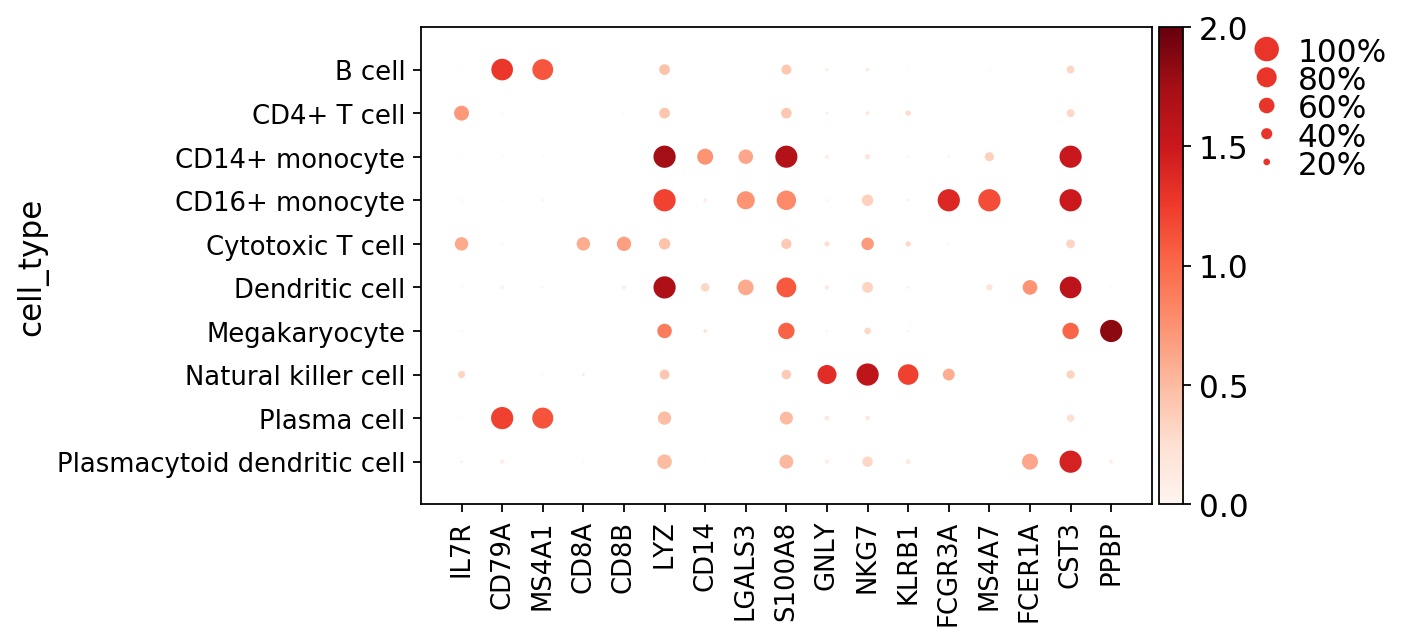

In [104]:
ax = sc.pl.dotplot(adata, marker_genes,
                   groupby='cell_type', save="_" + output_prefix + '.pdf',
                   log=True, expression_cutoff=0.1, vmax=2.0)

In [99]:
adata.obs.insert(len(adata.obs.columns), 'mutual_cell_type', adata.obs['louvain'].values.tolist())

In [100]:
mutual_cell_types = ['B cell', 'CD4+ T cell', 'CD14+ monocyte', 'CD16+ monocyte',
       'Cytotoxic T cell', 'Megakaryocyte']

In [101]:
for i, v in enumerate(adata.obs['cell_type'].values):
    if v in mutual_cell_types:
        adata.obs['mutual_cell_type'].values[i] = v
    else:
        adata.obs['mutual_cell_type'].values[i] = 'Other'

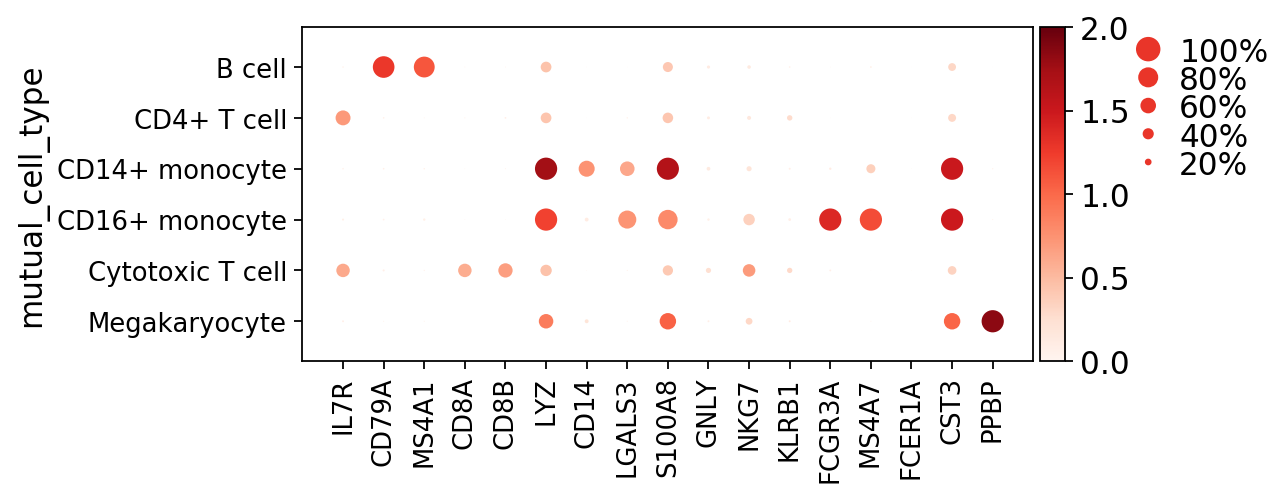

In [105]:
ax = sc.pl.dotplot(
    adata[adata.obs['mutual_cell_type'] != 'Other', :], marker_genes,
    groupby='mutual_cell_type', save="_" + output_prefix + '_mutual.pdf',
    log=True, expression_cutoff=0.1, vmax=2.0)

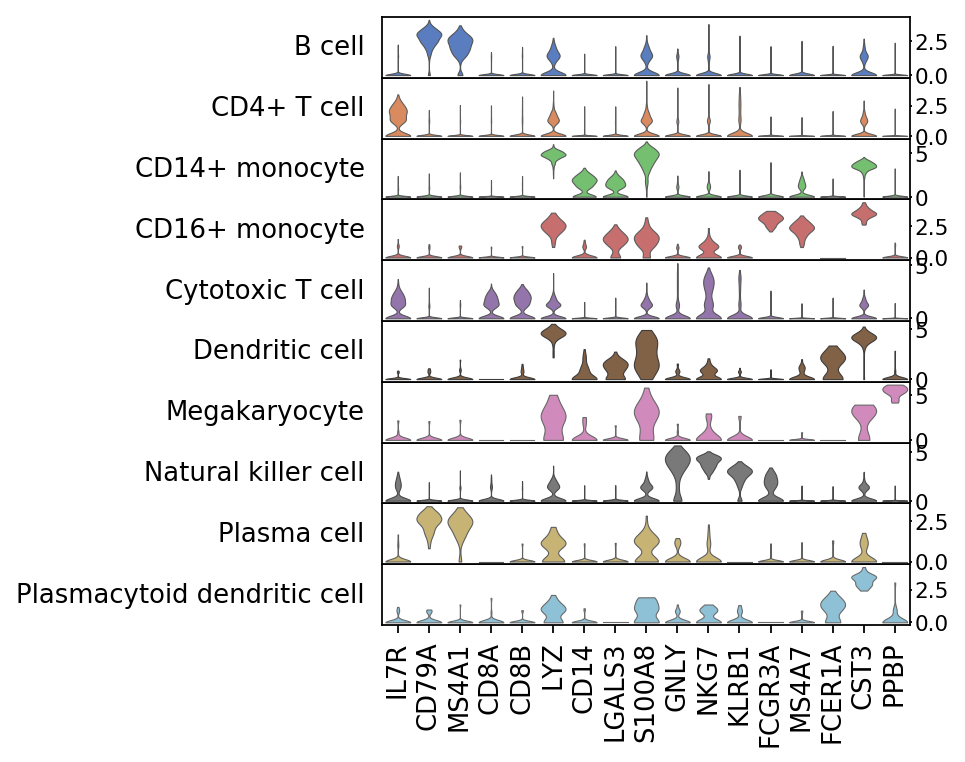

In [78]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='cell_type', rotation=90, save="_" + output_prefix + '.pdf')

In [ ]:
adata

In [ ]:
adata.write(results_file)